# Mixture of Gaussians Topic Model

In [11]:
import numpy as np
import bayespy as bp
import matplotlib.pyplot as plt

from pprint import pprint
from functools import reduce
from sklearn.preprocessing import normalize

%matplotlib inline

In [12]:
# Fail fast on floating point error.
np.seterr(all="raise")
# But ignore underflow
np.seterr(under="ignore")

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

## Construct Synthetic Problem

We will create an easily-identifiable synthetic dataset to verify that our algorithm behaves as we expect it. Start with a well-separated dictionary of Gaussian distributions, which we will recover.

In [52]:
import os
os.getcwd()

'/proj/learning/convbayes/src'

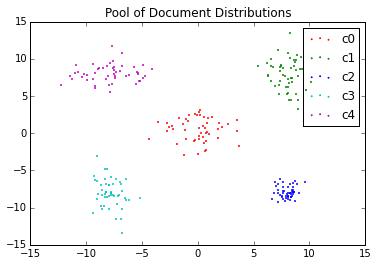

In [55]:
dictionary = [
    [np.zeros(2), 3*np.eye(2)],
    [np.array([8, 8]), np.diag([1, 3])],
    [np.array([8, -8]), np.diag([0.5, 0.5])],
    [np.array([-8, -8]), np.diag([1, 3])],
    [np.array([-8, 8]), np.diag([3, 1])]
    ]

cluster_colors = "rgbcm"

def viz_dictionary(n_samples=50):
    h = plt.figure()
    for i, (params, color) in enumerate(zip(dictionary, cluster_colors)):
        points = np.random.multivariate_normal(*params, size=n_samples)                
        
        plt.scatter(points[:,0], points[:,1], s=0.8, color=color, label="c%d" % i)
        
    plt.legend(loc='best')
    plt.title("Pool of Document Distributions")
    plt.xlim((-15,15))
    plt.ylim((-15,15))
    
    # HACK
    plt.savefig("plot.pdf", pad_inches=0)
        
viz_dictionary()    

Create 3 topics, one for just the center, one for the right side, and one for left side. Within each topic, bias the top half (clusters 1 and 4). Then, create 7 types of documents, one for each possible combination of topics. Bias the lower-numbered topic.

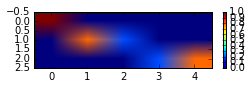

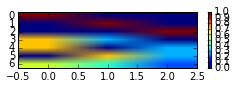

In [80]:
true_topics = np.array([
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.8, 0.2, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.2, 0.8]
    ])

true_document_dictionary = np.array([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.7, 0.3, 0.0],
        [0.7, 0.0, 0.3],
        [0.0, 0.7, 0.3],
        [0.6, 0.4, 0.2]
    ])

plt.figure(figsize=(4,1))
plt.imshow(true_topics, aspect="auto")
plt.colorbar()
plt.savefig("true_topics.pdf")
plt.show()

plt.figure(figsize=(4,1))
plt.imshow(true_document_dictionary, aspect="auto")
plt.colorbar()
plt.savefig("true_document_dictionary.pdf")
plt.show()

In [15]:
true_topics[1]

array([ 0. ,  0.8,  0.2,  0. ,  0. ])

Generate many copies of each document dictionary. Each document is 5-100 words long.

In [16]:
# Helper function
def categorical(pvals, n):
    mults = np.random.multinomial(1, pvals, n)
    return np.argmax(mults, 1)

categorical([0.1, 0.5, 0.4], 10)

array([1, 1, 2, 0, 2, 1, 0, 2, 1, 0])

20


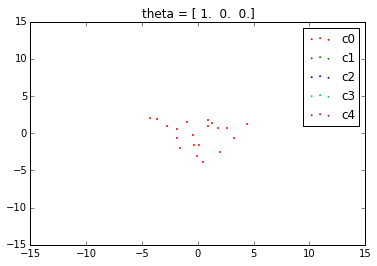

64


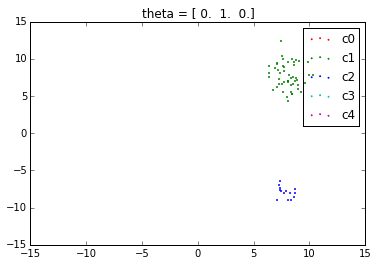

86


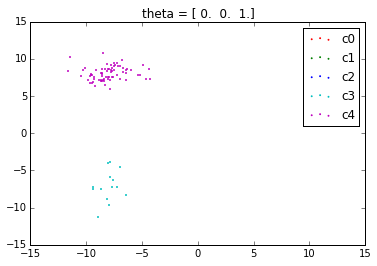

48


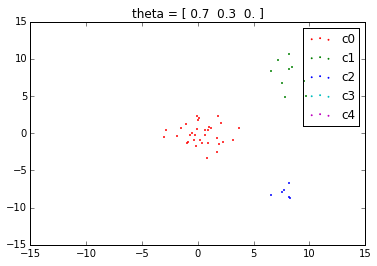

63


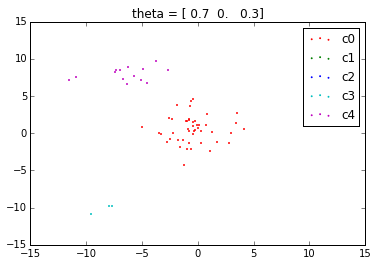

74


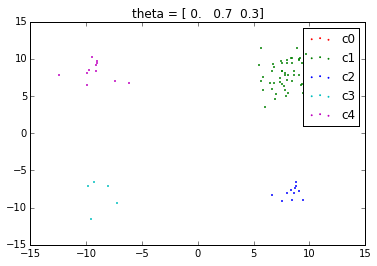

31


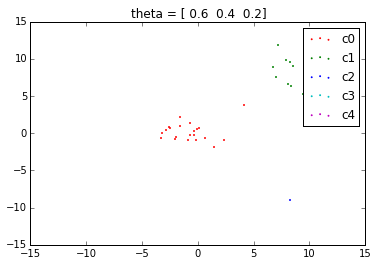

In [17]:
def sample_synthetic(copies=10, min_words=20, max_words=100, extra_dims=298):
    
    n_docs = len(true_document_dictionary) * copies    
    
    docs                     = [None] * n_docs
    true_thetas              = [None] * n_docs
    true_topic_assignments   = [None] * n_docs
    true_cluster_assignments = [None] * n_docs
    
    n = 0
    for theta in true_document_dictionary:
        for i in range(copies):
            # Copy the theta vector
            true_thetas[n] = theta
            
            # Sample the document length.
            n_words = np.random.randint(min_words, max_words + 1)
            
            # Sample the topic assignments.
            true_topic_assignments[n] = categorical(theta, n_words)
            
            # At each topic assignment, sample the cluster assignments.      
            true_cluster_assignments[n] = np.zeros(n_words)
            for k in range(len(true_topics)):
                ix = true_topic_assignments[n] == k
                true_cluster_assignments[n][ix] = categorical(true_topics[k], np.sum(ix))
            
            # At each cluster assignment, sample from the cluster.
            docs[n] = np.zeros((n_words, 2))
            for t in range(len(dictionary)):
                ix = true_cluster_assignments[n] == t
                docs[n][ix] = np.random.multivariate_normal(*dictionary[t], size=np.sum(ix))
            
            n += 1
    
    return docs, true_thetas, true_topic_assignments, true_cluster_assignments

docs, true_thetas, true_topic_assignments, true_cluster_assignments = sample_synthetic()

def viz_one_doc(doc, theta, topic_assignments, cluster_assignments):
    h = plt.figure()
    
    print(len(doc))
    
    for t in range(len(dictionary)):
        ix = cluster_assignments == t
        plt.scatter(doc[ix,0], doc[ix,1], s=0.8, color=cluster_colors[t], label="c%d" % t)
            
    plt.title("theta = %s" % theta)
    plt.legend(loc="best")
    plt.xlim((-15,15))
    plt.ylim((-15,15))
    plt.show()

    
# Plot a representative of each.
# TODO: Remove hardcoding.
for nn in range(0, 70, 10):
    viz_one_doc(docs[nn], true_thetas[nn], true_topic_assignments[nn], true_cluster_assignments[nn])

## Model Code

Run with more topics and clusters than necessary.

In [18]:
# K counts topics, T counts clusters.

# TODO: Remove the observe step; we want to use SVI.

def setup_gtm(docs, K=10, T=100, alpha=1e-6, gamma=1e-6, a=1e-6, b=1e-6, initialize_from_prior=False):
    # Compute dimensions
    n_docs = len(docs)
    D = docs[0].shape[1]
    
    # Topic plate
    beta  = bp.nodes.Dirichlet(alpha * np.ones(T), plates=(K,), name="beta")
    
    # Clusters plate.
    # We implement diagonal Gaussians by using D independent Gaussians per plate.
    tau   = bp.nodes.Gamma(1e-6, 1e-6, plates=(D,T), name="tau")    
    mu    = bp.nodes.GaussianARD(0, tau, plates=(D,T), name="mu")

    # Local variables
    thetas = [None] * n_docs
    zs     = [None] * n_docs
    cs     = [None] * n_docs
    xs     = [None] * n_docs
    
    if initialize_from_prior:
        beta.initialize_from_prior()
        tau.initialize_from_prior()
        mu.initialize_from_prior()                
    
    for n in range(n_docs):
        n_words   = docs[n].shape[0]
        
        thetas[n] = bp.nodes.Dirichlet(gamma * np.ones(K), name="thetas[n]")
        
        # The following variables are plated according to n_words.        
        zs[n]     = bp.nodes.Categorical(thetas[n], plates=(n_words,1), name="zs[n]")
        
        # The cluster assignment is a mixture of categoricals.
        cs[n]     = bp.nodes.Mixture(zs[n], bp.nodes.Categorical, beta, name="cs[n]")
        
        # Finally, the output is a mixture of Gaussians
        xs[n]     = bp.nodes.Mixture(cs[n], bp.nodes.GaussianARD, mu, tau, name="xs[n]")
    
        # This is necessary to get a finite bound prior to any mean field iterations,
        # so we can run SVI. However, you must randomize the indicators prior to the
        # first mean field iterations, or you will get garbage results.
        
        if initialize_from_prior:        
            thetas[n].initialize_from_prior()                
            zs[n].initialize_from_prior()
            cs[n].initialize_from_prior()

        # vvv Evaluate the veracity of the statement below vvv
        # IMPORTANT! All the xs[n] must be observed from the get-go. Otherwise the
        # algorithm will attempt a full-covariance variational approximation.
        xs[n].observe(docs[n])        
    
    model_vars = [beta, tau, mu] + thetas + zs  + cs + xs
    
    finite_elbos = [np.isfinite(v.lower_bound_contribution()) for v in model_vars]
    assert np.all(finite_elbos), "Some variable was initialized to have infinite lower bound."
    
    if False:
        for i, v in enumerate(thetas):
            print("theta[%d] = %g" % (i, v.lower_bound_contribution()))
        for i, v in enumerate(zs):
            print("zs[%d] = %g" % (i, v.lower_bound_contribution()))
        for i, v in enumerate(cs):
            print("cs[%d] = %g" % (i, v.lower_bound_contribution()))
        
    vars_dict = { "beta": beta, 
                  "tau": tau,
                  "mu": mu,
                  "thetas": thetas,
                  "zs": zs,
                  "cs": cs,
                  "xs": xs }
    
    Q = bp.inference.VB(*model_vars)
    
    if initialize_from_prior:
        print("Initial ELBO, initialized from prior = %g" % Q.loglikelihood_lowerbound())
        
    return Q, vars_dict
    
def randomize_indicators(n):   
    vars_dict["zs"][n].initialize_from_random()
    vars_dict["cs"][n].initialize_from_random()    
    
def run_gtm_batch(Q, vars_dict, docs, max_iter=400):
    for n in range(len(docs)):
        randomize_indicators(n)
        
    Q.update(repeat=max_iter)

    # Conjugate gradients optimization FAIL. Just stick with MF instead.
#    Q.optimize(*Q.model, maxiter=max_iter, collapsed=vars_dict["zs"] + vars_dict["cs"])
#    Q.optimize(*Q.model, riemannian=True, maxiter=max_iter, collapsed=vars_dict["zs"])
    
    
# rm_params: Robbins Monro parameters. (init_step, forget, exponent)    
def run_gtm_svi(Q, vars_dict, docs, rm_params=(1e-2, 1, 0.7), n_epochs=100, n_minibatch=1, max_local_iters=10):
    Q.ignore_bound_checks = True
        
    n_docs = len(docs)
    
    mb_multiplier = n_docs / n_minibatch
    
    n_iters = int(np.ceil(n_epochs * mb_multiplier))
    
    global_vars = [vars_dict["beta"], vars_dict["tau"], vars_dict["mu"]]
        
    def local_vars_doc(n):
        return [vars_dict[name][n] for name in ["thetas", "zs", "cs", "xs"]]
    
    times_sampled = np.zeros(n_docs)
    elbos = np.zeros(n_iters)
    for t in range(n_iters):
        minibatch = np.random.choice(n_docs, size=n_minibatch, replace=False)
        new_docs  = [n for n in minibatch if times_sampled[n] == 0]
        
#        print("new_docs", new_docs)
        
        for n in new_docs:
            randomize_indicators(n)
        
        times_sampled[minibatch] += 1        
        
        local_vars = sum(map(local_vars_doc, minibatch), [])
        Q.update(*local_vars, repeat=max_local_iters, verbose=False)
                
        # SVI step
        step_sz = rm_params[0] * (t + rm_params[1]) ** (-rm_params[2])
        Q.gradient_step(*global_vars, scale=mb_multiplier * step_sz)
        
        # This will not be a good estimate...
        elbos[t] = Q.loglikelihood_lowerbound()
        
        print("SVI iter %d / %d (Epoch %d / %d), ELBO = %g" % (
                t, n_iters, np.floor(t / mb_multiplier), n_epochs, elbos[t]))

    return elbos        
        
# Pad with extra zeros to make the problem harder
# This function only works a docs matrix
def pad_vec(doc, extra_zeros):
    ret = np.zeros((doc.shape[0], doc.shape[1] + extra_zeros))
    ret[:,:doc.shape[1]] = doc
    return ret

def run_gtm_padded():
    extra_zeros = 298
    padded_docs = [pad_vec(doc, extra_zeros) for doc in docs]
    Q, vars_dict = setup_gtm(padded_docs)
    run_gtm_batch(Q, vars_dict, padded_docs)
       
Q, vars_dict = setup_gtm(docs)
run_gtm_batch(Q, vars_dict, docs)
#run_gtm_svi(Q, vars_dict, docs, n_minibatch=69)
#run_gtm_svi(Q, vars_dict, docs, n_minibatch=1)
#run_gtm_svi(Q, vars_dict, docs, n_minibatch=70)

Iteration 1: loglike=-5.342252e+04 (0.420 seconds)
Iteration 2: loglike=-5.112254e+04 (0.480 seconds)
Iteration 3: loglike=-4.960378e+04 (0.420 seconds)
Iteration 4: loglike=-4.908608e+04 (0.420 seconds)
Iteration 5: loglike=-4.870582e+04 (0.410 seconds)
Iteration 6: loglike=-4.856030e+04 (0.420 seconds)
Iteration 7: loglike=-4.831920e+04 (0.420 seconds)
Iteration 8: loglike=-4.782221e+04 (0.460 seconds)
Iteration 9: loglike=-4.700441e+04 (0.460 seconds)
Iteration 10: loglike=-4.564605e+04 (0.420 seconds)
Iteration 11: loglike=-4.387164e+04 (0.430 seconds)
Iteration 12: loglike=-4.196951e+04 (0.420 seconds)
Iteration 13: loglike=-3.954022e+04 (0.450 seconds)
Iteration 14: loglike=-3.650006e+04 (0.410 seconds)
Iteration 15: loglike=-3.322174e+04 (0.420 seconds)
Iteration 16: loglike=-3.005508e+04 (0.410 seconds)
Iteration 17: loglike=-2.700394e+04 (0.420 seconds)
Iteration 18: loglike=-2.486386e+04 (0.410 seconds)
Iteration 19: loglike=-2.376060e+04 (0.400 seconds)
Iteration 20: loglike

## Analyze Posterior

First sanity check is to visualize the GMM.

In [21]:
def posterior_mean_assigns_doc(vars_dict, n):
    mean_zs = np.mean(np.squeeze(vars_dict["zs"][n].get_moments()[0], 1), 0)
    mean_cs = np.mean(np.squeeze(vars_dict["cs"][n].get_moments()[0], 1), 0)
    
    return (mean_zs, mean_cs)

def posterior_mean_assigns(vars_dict):
    doc_mean_zs_tup, doc_mean_cs_tup = list(zip(*[posterior_mean_assigns_doc(vars_dict, n) for n in range(len(docs))]))
    doc_mean_zs = np.vstack(doc_mean_zs_tup)
    doc_mean_cs = np.vstack(doc_mean_cs_tup)
    
    return doc_mean_zs, doc_mean_cs

The clusters seem to be well-recovered, but the topics not so much.

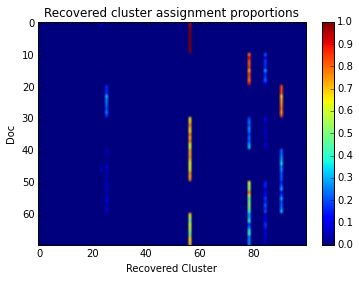

Cluster 23, Fraction 0.00290351
Mean     : [-1.16594452 -0.86381292]
Variance : [ 17.20776649  11.08854066]
Cluster 25, Fraction 0.0459948
Mean     : [-7.94514955 -7.95864042]
Variance : [ 1.32719722  3.06551673]
Cluster 56, Fraction 0.428434
Mean     : [-0.0121668  -0.03340932]
Variance : [ 2.87224335  2.9091388 ]
Cluster 78, Fraction 0.274407
Mean     : [ 8.01574192  7.95494332]
Variance : [ 1.08757882  2.87393349]
Cluster 84, Fraction 0.0692072
Mean     : [ 8.05800355 -7.9835359 ]
Variance : [ 0.71450069  0.75847503]
Cluster 90, Fraction 0.179053
Mean     : [-8.01573232  8.00753155]
Variance : [ 3.07443898  1.09685399]


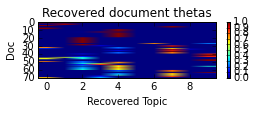

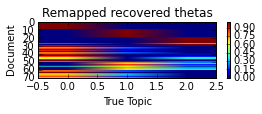

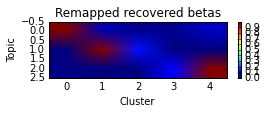

{84: 2, 23: 0, 56: 0, 25: 3, 90: 4, 78: 1} {0: 0, 1: 0, 2: 2, 3: 1, 4: 1, 5: 0, 6: 2, 7: 0, 8: 1, 9: 0} [[ 0.95        0.          0.05      ]
 [ 0.95454545  0.          0.04545455]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          0.98461538  0.01538462]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          0.          1.        ]
 [ 0.          0.          1.        ]
 [ 0.          0.          1.        ]

In [81]:
# match maps dimension in v to dimension in output.
def remap(in_v, match):
    out_dim = max(match.values()) + 1
    out_v   = np.zeros(out_dim)
    
    for in_i, out_i in match.items():
        out_v[out_i] += in_v[in_i]
        
    return out_v    

def plot_nonempty_clusters(vars_dict):   
    doc_mean_zs, doc_mean_cs = posterior_mean_assigns(vars_dict)
    total_mean_clusters      = np.mean(doc_mean_cs, 0)
    nonempty_clusters        = np.flatnonzero(total_mean_clusters)
            
    total_mean_topics        = np.mean(doc_mean_zs, 0)

    # Cluster stuff
    plt.figure()
    plt.imshow(doc_mean_cs, aspect="auto")
    plt.colorbar()
    plt.xlabel("Recovered Cluster")
    plt.ylabel("Doc")
    plt.title("Recovered cluster assignment proportions")             
    plt.show()
    
    cluster_match = {}
    
    for t in nonempty_clusters:
        t = int(t) # NumPy, you are stupid.
        
        means = vars_dict["mu"][:,t].get_moments()[0]
        
        print("Cluster %d, Fraction %g" % (t, total_mean_clusters[t]))
        print("Mean     : %s"      % means)
        print("Variance : %s" % (1.0 / vars_dict["tau"][:,t].get_moments()[0]))
        
        # Match with a dictionary
        dists = []
        for t_true, params_true in enumerate(dictionary):
            dists.append(np.linalg.norm(means - params_true[0]))
        
        cluster_match[t] = np.argmin(dists)
    
    # TODO: Match topics to ground truth.
    
    # Topic stuff
    plt.figure(figsize=(4,1))
    plt.imshow(doc_mean_zs, aspect="auto")
    plt.colorbar()
    plt.xlabel("Recovered Topic")
    plt.ylabel("Doc")
    plt.title("Recovered document thetas")                
    plt.show()
        
    beta_mean = np.exp(vars_dict["beta"].get_moments()[0])        
        
    # Iterate rows of the recovered topics
    n_true_clusters = len(dictionary)
    topic_match = {}
    for k, recovered_topic in enumerate(beta_mean):        
        mapped_topic = remap(recovered_topic, cluster_match)
            
        # Find the nearest L1 norm true topic        
        dists = []
        for k_true, true_topic in enumerate(true_topics):
            dists.append(np.linalg.norm(mapped_topic - true_topic, 1))
        
#        print(dists)
        topic_match[k] = np.argmin(dists)
    
    n_docs        = doc_mean_zs.shape[0]
    n_true_topics = max(topic_match.values()) + 1       
    mapped_thetas  = np.zeros((n_docs, n_true_topics))
    
    for n, recovered_theta in enumerate(doc_mean_zs):
        mapped_thetas[n,:] = remap(recovered_theta, topic_match)
            
    plt.figure(figsize=(4,1))
    plt.imshow(mapped_thetas, aspect="auto")
    plt.xlabel("True Topic")
    plt.ylabel("Document")
    plt.title("Remapped recovered thetas")
    plt.colorbar()    
    plt.savefig("Remapped_recovered_thetas.pdf", pad_inches=0)    
#    plt.savefig("Remapped_recovered_thetas.eps")
    plt.show()    

    # The actual topic
    
    mapped_betas1 = np.zeros((beta_mean.shape[0], 5))
    for n, beta in enumerate(beta_mean):
        mapped_betas1[n,:] = remap(beta, cluster_match)
    
    mapped_betas2 = np.zeros((3, 5))
    for k in range(5):
        mapped_betas2[:,k] = remap(mapped_betas1[:,k], topic_match)
    
    mapped_betas2 = normalize(mapped_betas2)
    
    plt.figure(figsize=(4,1))
    plt.imshow(mapped_betas2, aspect="auto")
    plt.xlabel("Cluster")
    plt.ylabel("Topic")
    plt.title("Remapped recovered betas")
    plt.colorbar()
#    plt.tight_layout()    
    plt.savefig("Remapped_recovered_betas.pdf", pad_inches=0)  
#    plt.savefig("Remapped_recovered_betas.eps")
    plt.show()
    
    
    return cluster_match, topic_match, mapped_thetas
        
# Map the recovered cluster id to the true cluster id.    
cluster_match, topic_match, mapped_thetas = plot_nonempty_clusters(vars_dict)
print (cluster_match, topic_match, mapped_thetas)

Eventually look at the recovered theta values, but for now, I have good enough assurance.

In [23]:
def var_to_categorical(v):    
    return np.argmax(np.squeeze(v.get_moments()[0], 1), 1)

def compute_global_stats(vars_dict, docs, K=10, T=100):
    n_docs = len(docs)
    
    topic_counts   = np.zeros(K)
    cluster_counts = np.zeros(T)    
    
    for n in range(n_docs):
        
    
    

SyntaxError: unexpected EOF while parsing (<ipython-input-23-49f637898507>, line 13)

In [24]:
def plot_post_one_doc(vars_dict, n):
    print("Doc %d has %d vecs." % (n, len(docs[n])))
    c = np.argmax(np.squeeze(vars_dict["cs"][n].get_moments()[0], 1), 1)
    print(c)
#    print(np.sum(c, 0))
    
    print(np.exp(vars_dict["thetas"][n].get_moments()[0]))
    
plot_post_one_doc(vars_dict, 11)

Doc 11 has 32 vecs.
[78 78 78 78 78 78 84 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78
 78 84 78 84 78 78 78]
[ 0.          0.          0.          0.          0.99999971  0.          0.
  0.          0.          0.        ]


In [25]:
len(docs)

70

In [26]:
np.argmax(np.squeeze(vars_dict["cs"][65].get_moments()[0], 1), 1)

array([78, 56, 56, 78, 56, 84, 78, 56, 56, 56, 56, 84, 78, 78, 56, 56, 56,
       56, 78, 56, 56, 56, 78, 56, 78, 78, 78, 56, 78, 56, 56, 78, 56, 78,
       56, 56, 78, 84, 78, 78, 56, 78, 78, 56, 56, 56, 56, 56, 56, 56, 56,
       78, 56, 78, 78, 56, 78, 56, 56])

In [27]:
vars_dict["thetas"][0]

In [28]:
thetas = vars_dict["thetas"]

In [29]:
np.exp(thetas[0].get_moments()[0])

array([ 0.        ,  0.        ,  0.02878967,  0.        ,  0.        ,
        0.        ,  0.        ,  0.94872904,  0.        ,  0.        ])

In [30]:
t1 = thetas[0]
t1.get_parameters()

[array([  1.00000000e-06,   1.00000000e-06,   1.00000100e+00,
          1.00000000e-06,   1.00000000e-06,   1.00000000e-06,
          1.00000000e-06,   1.90000010e+01,   1.00000000e-06,
          1.00000000e-06])]

Moments are $E[\log X]$. This is confirmed by the documentation http://www.bayespy.org/dev_api/generated/generated/bayespy.inference.vmp.nodes.dirichlet.DirichletDistribution.compute_moments_and_cgf.html#bayespy.inference.vmp.nodes.dirichlet.DirichletDistribution.compute_moments_and_cgf. (I think it's because whenever Dirichlet is used in VB, only $E[\log X]$ is used, not $E[X]$. (However, categoricals use the true moments.)

In [31]:
import scipy as sp
np.allclose(
    sp.special.psi(t1.get_parameters()) - sp.special.psi(np.sum(t1.get_parameters())),
    t1.get_moments()[0]
    )

True

In [32]:
t1.get_moments()[0]

array([ -1.00000355e+06,  -1.00000355e+06,  -3.54773852e+00,
        -1.00000355e+06,  -1.00000355e+06,  -1.00000355e+06,
        -1.00000355e+06,  -5.26320376e-02,  -1.00000355e+06,
        -1.00000355e+06])

In [33]:
def recover_clusters(zs):
    max_k = np.max(zs)
    clusters = []
    for k in range(max_k):
        ix = zs == k
        Nk = np.sum(ix)
        if Nk > 0:
            clusters.append(set(np.flatnonzero(ix)))
    
    return clusters